# Urban and rural surrounding areas selection

***
> This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0)
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

## Load libraries

Here we load the required libraries to execute the notebook. Note that specific code from dedicated scripts (`utils.py`, `urban_areas.py`, ...) is also loaded here.

In [1]:
import os
import numpy as np
import xarray as xr
import cf_xarray as cfxr
from pathlib import Path
import glob
import re
import geopandas as gpd
import pandas as pd


import xesmf as xe



from urbanmask.urban_areas import (
    Urban_vicinity,
)

from urbanmask.UHI_plot_functions import (
    plot_climatology,
    plot_annual_cicle,
    plot_daily_cicle
)

from urbanmask.utils import (
    kelvin2degC,
    traverseDir,
    fix_360_longitudes,
)

## Input parameters

These parameters define the behaviour of the notebook, by selecting the `city`, `variable`, and some other items which are mostly self-explanatory. _(Explain here those with are not)_

In [4]:
city = 'Cordoba'
lon_city =  -64.1888
lat_city = -31.4201

domain = 'CSAM-4i'
model = 'UCAN'
version = "v1"
scenario = "evaluation"

urban_th = 60
urban_sur_th = 1
orog_diff = 100
sftlf_th = 70
scale = 2
min_city_size = 3
lon_lim = 1
lat_lim = 1

urban_var = 'sftuf'

variable='tasmax'

Create a directory to save the results for this particular city and model

In [5]:
base_output_dir = 'results'
if model in ['NCAR', 'UCAN']:
    output_dir = f"{base_output_dir}/{city}-{domain}_{model}-WRF433-{version}"
elif model in ['USP']:
    output_dir = f"{base_output_dir}/{city}-{domain}_{model}-RegCM471-{version}"
elif  model in ['ICTP']:
    output_dir = f"{base_output_dir}/{city}-{domain}_{model}-{version}-v0"
os.makedirs(output_dir, exist_ok = True)

Infer doman resolution in degrees and create filename

In [4]:
domain_resolution = int( re.search(r'(\d+)', domain.split('-')[1]).group(1))
base_filename = f'{city}-{domain}_{model}-{version}_{scenario}_r1i1p1f1'
if model in ['NCAR', 'UCAN']:
    base_filename = f'{city}-{domain}_{model}-WRF433-{version}_{scenario}_r1i1p1f1'
elif model in ['USP', 'ICTP']:
    base_filename = f'{city}-{domain}_{model}-RegCM471-{version}_{scenario}_r1i1p1f1'

## Define urban areas and vicinity

Add parameters to the function

In [5]:
URBAN = Urban_vicinity(
    urban_th, 
    urban_sur_th, 
    orog_diff, 
    sftlf_th,
    scale,
    min_city_size,
    lon_city,
    lat_city,
    lon_lim,
    lat_lim,
    model,
    domain,
    urban_var)

### Load static variables
Load static variables, such as urban fraction (sfturf), terrain elevation (orography) or land-sea fraction (sftlf).

In [6]:
root = f'/lustre/gmeteo/WORK/ASNA/projects/fpssam/03_FPS-SESA-ext-CPM/data/CORDEX-FPS-SESA/output/{domain}/{model}/*/evaluation/*/{model}-*/{version}/'
USP_version = "v"+version[-1]
if model == 'ICTP':
    root = f'/lustre/gmeteo/WORK/ASNA/projects/fpssam/03_FPS-SESA-ext-CPM/data/CORDEX-FPS-SESA/output/{domain}/USP/*/evaluation/*/USP-*/{USP_version}/'
root_urban = f'/lustre/gmeteo/WORK/ASNA/projects/fpssam/03_FPS-SESA-ext-CPM/data/CORDEX-FPS-SESA/output/CSAM-4/USP/ECMWF-ERA5/evaluation/r1i1p1f1/USP-RegCM471/{USP_version}/'

In [7]:
file_pattern = f'{root}fx/orog/orog_{domain}_*.nc'
file_list = glob.glob(file_pattern)
ds_orog = xr.open_dataset(file_list[0], engine='netcdf4')

file_pattern = f'{root}fx/sftlf/sftlf_{domain}_*.nc'
file_list = glob.glob(file_pattern)
ds_sftlf = xr.open_dataset(file_list[0], engine='netcdf4')

if model in ['USP','ICTP']:
    file_pattern = f'{root_urban}fx/sftimf/*'
    file_list = glob.glob(file_pattern)
    ds_sftuf_native = xr.open_dataset(file_list[0], engine='netcdf4')
    ds_sftuf_native['sftuf'] = (ds_sftuf_native['sftimf']) / 1e40

else: 
    file_pattern = f'{root}fx/landuse/landuse_{domain}_*.nc'
    file_list = glob.glob(file_pattern)
    ds_sftuf = xr.open_dataset(file_list[0], engine='netcdf4')
    ds_sftuf['sftuf'] = (ds_sftuf['landuse'] == 13)*100

Crop area around de city

In [8]:
ds_orog = URBAN.crop_area_city(ds_orog, domain_resolution)
ds_sftlf = URBAN.crop_area_city(ds_sftlf, domain_resolution)
if model in ['USP','ICTP']:
    
    # Crear un remapeador con nearest neighbor
    regridder = xe.Regridder(ds_sftuf_native, ds_orog, method='nearest_s2d')
    
    # Aplicar la interpolación
    ds_sftuf = regridder(ds_sftuf_native)

else:
    ds_sftuf = URBAN.crop_area_city(ds_sftuf, domain_resolution)

In [9]:
def crop_area(ds, lat_city, lon_city, range_size, 
              y, x, lat, lon):
    
    iy = ds[y]; jx = ds[x]
    xlat = ds[lat]; xlon = ds[lon]

    # Step 1: Find the closest indices
    # Flatten the latitude and longitude arrays
    flat_lat = xlat.values.flatten()
    flat_lon = xlon.values.flatten()
    
    # Compute the distances
    distances = np.sqrt((flat_lat - lat_city)**2 + (flat_lon - lon_city)**2)
    
    # Find the index of the minimum distance
    min_index = np.argmin(distances)
    
    # Get the 2D index from the 1D index
    iy_index, jx_index = np.unravel_index(min_index, xlat.shape)
    
    # Step 2: Define a range around this point
    
    iy_start = max(iy_index - range_size, 0)
    iy_end = min(iy_index + range_size, len(iy) - 1)
    
    jx_start = max(jx_index - range_size, 0)
    jx_end = min(jx_index + range_size, len(jx) - 1)
    
    # Step 3: Select the area
    subset = ds.isel({y:slice(iy_start, iy_end), x:slice(jx_start, jx_end)})

    return subset

Define masks using the parameters above

In [10]:
sftuf_mask, sftuf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sftuf, 
    ds_orog, 
    ds_sftlf
)

### Define rural vicinity areas

We use an iterative algorithm to select the urban vicinity excluding masked areas

In [11]:
urmask = URBAN.select_urban_vicinity(
    sftuf_mask, 
    orog_mask,
    sftlf_mask,
    sftuf_sur_mask
)

We can plot the masks and the urban vs vicinity areas. The latter are are passed via the `urban_areas` parameter. They are hidden if set to `None`.

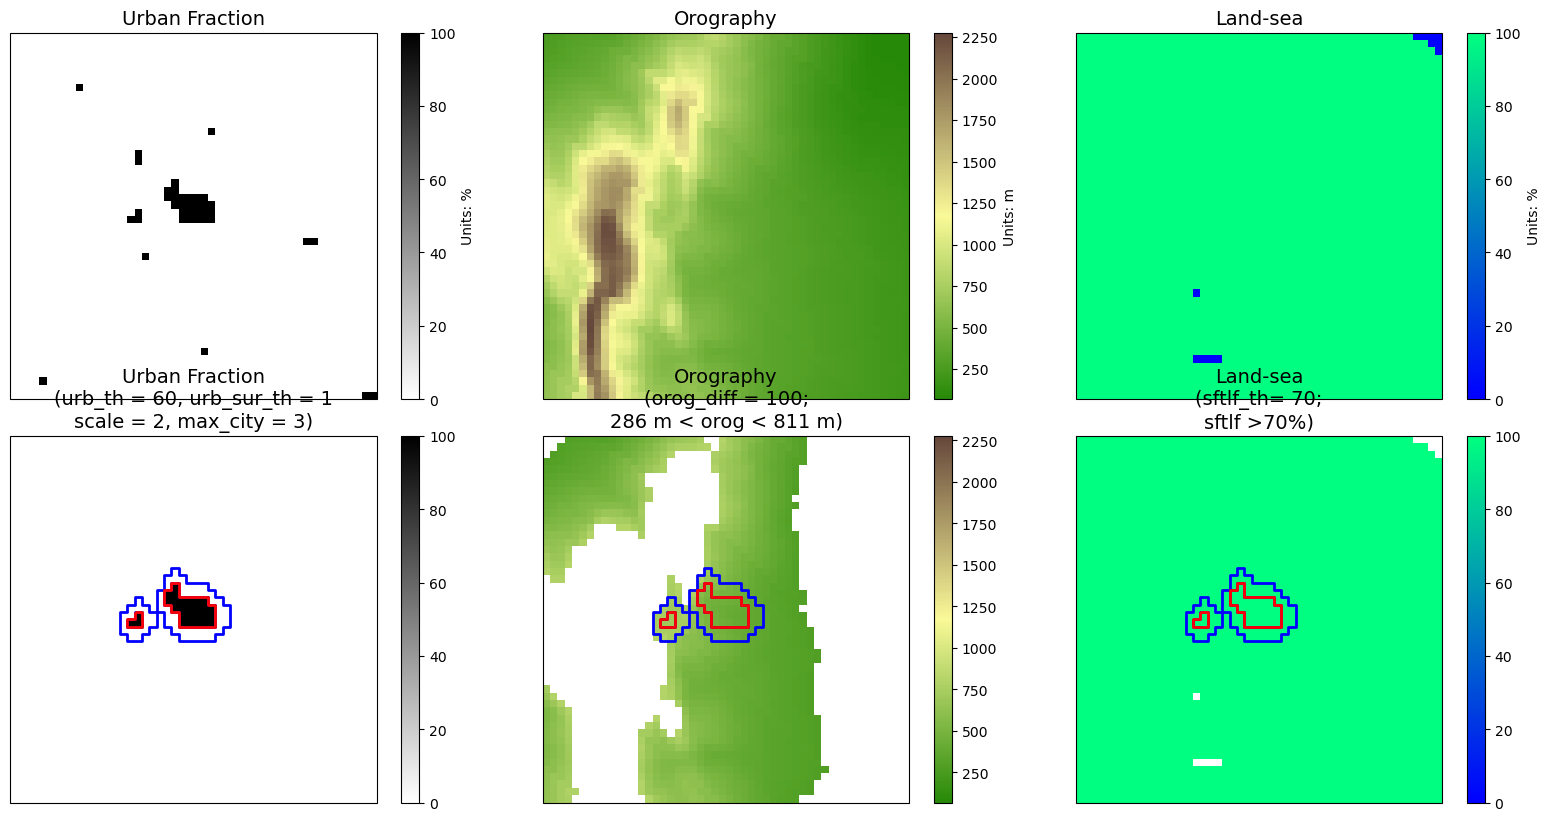

In [12]:
fig = URBAN.plot_static_variables(ds_sftuf, ds_orog, ds_sftlf,
                                 sftuf_mask, orog_mask, sftlf_mask,
                                 urban_areas = urmask)
fig.savefig(f"{output_dir}/urmask_{base_filename}_fx.pdf", bbox_inches='tight')

Save these masks and urban fraction to NetCDF

In [13]:
urmask.to_netcdf(f"{output_dir}/urmask_{base_filename}_fx.nc")
ds_sftuf.rename_vars({'sftuf': 'sfturf'}).to_netcdf(f"{output_dir}/sfturf_{base_filename}_fx.nc")

## Calculate urban heat island effect

### Load climate variable

In [14]:
if model == 'ICTP':
    root = f'/lustre/gmeteo/WORK/ASNA/projects/fpssam/03_FPS-SESA-ext-CPM/data/CORDEX-FPS-SESA/output/{domain}/{model}/*/evaluation/*/{model}-*/v0/'

In [15]:
file_pattern = f'{root}day/{variable}/*'
files = np.sort(glob.glob(file_pattern))
ds_RCM = xr.open_mfdataset(files, concat_dim='time', combine='nested')
ds_RCM = kelvin2degC(ds_RCM, variable)
ds_RCM = fix_360_longitudes(ds_RCM)
ds_RCM = URBAN.crop_area_city(ds_RCM, domain_resolution).compute()

### Calculate periods of heatwaves

In [16]:
is_urban = urmask['urmask'] == 1
urban_mean = (ds_RCM[variable]
    .where(is_urban)
    .mean(dim = [ds_RCM.cf['Y'].name, ds_RCM.cf['X'].name])
    .compute()
)

In [17]:
percentil_95 = urban_mean.quantile(0.95, dim='time')
exceedance_urb = urban_mean > percentil_95
exceedance_times_urb = urban_mean['time'].where(exceedance_urb, drop=True)
exceedance_days_urb = exceedance_times_urb.dt.floor("D").values

In [31]:
df = pd.DataFrame({
    'city': city,
    'model': model,
    'version': version,
    'exceedance_times': exceedance_days_urb
})
output_file= f"{base_output_dir}/heatwave_urban.csv"
output_path = Path(output_file)
# Save CSV
if output_path.exists():
    df.to_csv(output_path, mode='a', header=False, index=False)
else:
    df.to_csv(output_path, mode='w', index=False)


In [23]:
is_urban = urmask['urmask'] == 0
rural_mean = (ds_RCM[variable]
    .where(is_urban)
    .mean(dim = [ds_RCM.cf['Y'].name, ds_RCM.cf['X'].name])
    .compute()
)

In [24]:
exceedance_rur = rural_mean > percentil_95

exceedance_times_rur = rural_mean['time'].where(exceedance_rur, drop=True)
exceedance_days_rur = exceedance_times_rur.dt.floor("D").values

In [25]:
df = pd.DataFrame({
    'city': city,
    'model': model,
    'version': version,
    'exceedance_times': exceedance_days_rur
})
output_file= f"{base_output_dir}/heatwave_rural.csv"
output_path = Path(output_file)
# Save CSV
if output_path.exists():
    df.to_csv(output_path, mode='a', header=False, index=False)
else:
    df.to_csv(output_path, mode='w', index=False)
